# Segmentation

## Let’s get to work!

In [2]:
# general imports:
import os
import importlib
from torch import nn, cuda
from torch import optim
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [28]:
# my imports (reload all modules):

from data.dataset import load_data_deep_crack
from models.unet_resnet34 import UNetResNet34
from models.unet_swin import UNetSwin
from models.unet import UNet
from training.metrics import DiceLoss
from training.train import train
from utils import save_model_files
from utils import log_training_result


import data.dataset
import models.unet_resnet34
import models.unet_swin
import models.unet
import training.metrics
import training.train
import utils
importlib.reload(data.dataset)
importlib.reload(models.unet_resnet34)
importlib.reload(models.unet_swin)
importlib.reload(models.unet)
importlib.reload(training.metrics)
importlib.reload(training.train)
importlib.reload(utils)

<module 'utils' from 'D:\\01_AdatMat_Elte\\03_THESIS\\concrete_crack_thesis\\src\\utils.py'>

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print(f'Number of visible CUDA devices: {cuda.device_count()}')
cuda.is_available()
# NOTE: when referring to a CUDA device, torch will only know about visible devices
#       so while currently we will be using gpu05
#       this will be device `cuda:0`

Number of visible CUDA devices: 1


True

#### Loading the data

In [5]:
data_source ='../../DeepCrack/dataset/DeepCrack'
train_image_dir = data_source + '/train_img'
train_mask_dir = data_source + '/train_lab'
test_image_dir = data_source + '/test_img'
test_mask_dir = data_source + '/test_lab'

In [ ]:
train_dl, val_dl, train_dataset, val_dataset = load_data_deep_crack(train_image_dir, train_mask_dir, [0.8, 0.2])

This gives us 240 train and 60 validation samples.


With CPU: 4m 12s


With CUDA: 3m 6s

In [5]:
# my imports (reload all modules):

from models.unet_swin import UNetSwin
import models.unet_swin
importlib.reload(models.unet_swin)

<module 'models.unet_swin' from 'D:\\01_AdatMat_Elte\\03_THESIS\\concrete_crack_thesis\\src\\models\\unet_swin.py'>

In [ ]:
import gc
# Define experiments: (layers_to_unfreeze, learning_rate)
experiments = [
    (['layers_3'], 1e-4),                       # B: Unfreeze layer4
    (['layers_2', 'layers_3'], 1e-5),           # C: Unfreeze layers 3,4
    (['layers_1', 'layers_2', 'layers_3'], 1e-5),# D: Unfreeze layers 2,3,4
    (None, 1e-5),                                # E: Unfreeze all
]

for i, (layers, lr) in enumerate(experiments, start=1):
    folder = f"swin_6_{i}/"
    
    print(f"=== Training experiment {i} | Unfreezing: {layers if layers is not None else 'ALL'} | LR: {lr} ===")

    model = UNetSwin(
        img_channels=3,
        mask_channels=1,
        base_channel_size=64
    )

    loss = DiceLoss()
    model.freeze_encoder_layers()
    model.unfreeze_encoder_layers(layers)

    optimizer = optim.Adam(params=model.parameters(), lr=lr)

    # Load logs from previous training (optional)
    dice_idcs = list(np.load('../saved_models/swin_2/dice_idcs.npy'))
    epoch_dice_idcs = list(np.load('../saved_models/swin_2/epoch_dice_idcs.npy'))
    val_dice_idcs = list(np.load('../saved_models/swin_2/val_dice_idcs.npy'))
    train_loss = list(np.load('../saved_models/swin_2/train_loss.npy'))
    val_loss = list(np.load('../saved_models/swin_2/val_loss.npy'))
    epoch_durations = list(np.load('../saved_models/swin_2/epoch_durations.npy'))
    best_model_wts = {}

    # Load pretrained weights
    model.load_state_dict(torch.load('../saved_models/swin_2/model_state_epoch_100.pth', weights_only=True))

    # Log config
    log_training_result('../saved_models/training_log_2.csv', {
        "timestamp": pd.Timestamp.now(),
        "weights_file": folder,
        "epochs": 100,
        "learning_rate": lr,
        "batch_size": 4,
        "accum_scale": 4,
        "comment": "Unfreeze layer",
        "augmentation": "rotate+randomCrop",
        "unfrezed layers": layers if layers is not None else "ALL"
    })
    model.save_trainable_layers_to_file('../saved_models/' + folder + 'trainable_layers.txt')
    # Train
    train(
        model, loss, optimizer,
        train_dl, val_dl,
        num_epochs=1,
        accum_scale=4,
        dice_idcs=dice_idcs,
        epoch_dice_idcs=epoch_dice_idcs,
        val_dice_idcs=val_dice_idcs,
        best_model_wts=best_model_wts,
        train_loss=train_loss,
        val_loss=val_loss,
        epoch_durations=epoch_durations,
        save_path='../saved_models/' + folder,
        n_epoch_save=1
    )
    del model
    del optimizer
    torch.cuda.empty_cache()
    gc.collect()  # Python garbage collection
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

=== Training experiment 1 | Unfreezing: ['layers_3'] | LR: 0.0001 ===


D:\01_AdatMat_Elte\03_THESIS\concrete_crack_thesis\src\utils.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


Train loss:  0.06296831369400024
Epoch  1 . finished.
Validation loss:  0.1161518394947052
save files
Epoch 1/2 completed in 8.63 seconds
Train loss:  0.06879165768623352
Epoch  2 . finished.
Validation loss:  0.11609077453613281
save files
Epoch 2/2 completed in 7.57 seconds
=== Training experiment 2 | Unfreezing: ['layers_2', 'layers_3'] | LR: 1e-05 ===


D:\01_AdatMat_Elte\03_THESIS\concrete_crack_thesis\src\utils.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


Train loss:  0.07049140334129333
Epoch  1 . finished.
Validation loss:  0.11658549308776855
save files
Epoch 1/2 completed in 14.70 seconds
Train loss:  0.06767666339874268
Epoch  2 . finished.
Validation loss:  0.11700600385665894
save files
Epoch 2/2 completed in 15.35 seconds
=== Training experiment 3 | Unfreezing: ['layers_1', 'layers_2', 'layers_3'] | LR: 1e-05 ===


D:\01_AdatMat_Elte\03_THESIS\concrete_crack_thesis\src\utils.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


Train loss:  0.07352620363235474
Epoch  1 . finished.
Validation loss:  0.11570179462432861
save files
Epoch 1/2 completed in 16.98 seconds
Train loss:  0.13421940803527832
Epoch  2 . finished.
Validation loss:  0.11507290601730347
save files
Epoch 2/2 completed in 20.84 seconds
=== Training experiment 4 | Unfreezing: ALL | LR: 1e-05 ===


D:\01_AdatMat_Elte\03_THESIS\concrete_crack_thesis\src\utils.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


Train loss:  0.0630386471748352
Epoch  1 . finished.
Validation loss:  0.11640247702598572
save files
Epoch 1/2 completed in 20.99 seconds
Train loss:  0.07346349954605103
Epoch  2 . finished.
Validation loss:  0.11648869514465332
save files
Epoch 2/2 completed in 23.68 seconds


In [ ]:
import gc
# Define experiments: (layers_to_unfreeze, learning_rate)
experiments = [
    (['layers_3'], 1e-4),                       # B: Unfreeze layer4
    (['layers_2', 'layers_3'], 1e-5),           # C: Unfreeze layers 3,4
    (['layers_1', 'layers_2', 'layers_3'], 1e-5),# D: Unfreeze layers 2,3,4
    (None, 1e-5),                                # E: Unfreeze all
]

for i, (layers, lr) in enumerate(experiments, start=1):
    folder = f"swin_6_{i}/"
    
    print(f"=== Training experiment {i} | Unfreezing: {layers if layers is not None else 'ALL'} | LR: {lr} ===")

    model = UNetSwin(
        img_channels=3,
        mask_channels=1,
        base_channel_size=64
    )

    loss = DiceLoss()
    model.freeze_encoder_layers()
    model.unfreeze_encoder_layers(layers)
    model.print_trainable_layers()

=== Training experiment 1 | Unfreezing: ALL | LR: 1e-05 ===
stem1.0.weight: requires_grad=True
stem1.0.bias: requires_grad=True
stem1.1.weight: requires_grad=True
stem1.1.bias: requires_grad=True
stem2.0.weight: requires_grad=True
stem2.0.bias: requires_grad=True
stem2.1.weight: requires_grad=True
stem2.1.bias: requires_grad=True
encoder.backbone.patch_embed.proj.weight: requires_grad=True
encoder.backbone.patch_embed.proj.bias: requires_grad=True
encoder.backbone.patch_embed.norm.weight: requires_grad=True
encoder.backbone.patch_embed.norm.bias: requires_grad=True
encoder.backbone.layers_0.blocks.0.norm1.weight: requires_grad=True
encoder.backbone.layers_0.blocks.0.norm1.bias: requires_grad=True
encoder.backbone.layers_0.blocks.0.attn.relative_position_bias_table: requires_grad=True
encoder.backbone.layers_0.blocks.0.attn.qkv.weight: requires_grad=True
encoder.backbone.layers_0.blocks.0.attn.qkv.bias: requires_grad=True
encoder.backbone.layers_0.blocks.0.attn.proj.weight: requires_gra

In [11]:
for name, param in model.encoder.named_parameters():
    print(name)


backbone.patch_embed.proj.weight
backbone.patch_embed.proj.bias
backbone.patch_embed.norm.weight
backbone.patch_embed.norm.bias
backbone.layers_0.blocks.0.norm1.weight
backbone.layers_0.blocks.0.norm1.bias
backbone.layers_0.blocks.0.attn.relative_position_bias_table
backbone.layers_0.blocks.0.attn.qkv.weight
backbone.layers_0.blocks.0.attn.qkv.bias
backbone.layers_0.blocks.0.attn.proj.weight
backbone.layers_0.blocks.0.attn.proj.bias
backbone.layers_0.blocks.0.norm2.weight
backbone.layers_0.blocks.0.norm2.bias
backbone.layers_0.blocks.0.mlp.fc1.weight
backbone.layers_0.blocks.0.mlp.fc1.bias
backbone.layers_0.blocks.0.mlp.fc2.weight
backbone.layers_0.blocks.0.mlp.fc2.bias
backbone.layers_0.blocks.1.norm1.weight
backbone.layers_0.blocks.1.norm1.bias
backbone.layers_0.blocks.1.attn.relative_position_bias_table
backbone.layers_0.blocks.1.attn.qkv.weight
backbone.layers_0.blocks.1.attn.qkv.bias
backbone.layers_0.blocks.1.attn.proj.weight
backbone.layers_0.blocks.1.attn.proj.bias
backbone.lay

In [7]:
model = UNetSwin(   img_channels = 3,
                mask_channels = 1,
                base_channel_size = 64)  
loss = DiceLoss()
optimizer = optim.Adam(params = model.parameters(), lr = 5*1e-4)

dice_idcs = []
epoch_dice_idcs = []
val_dice_idcs = []
train_loss = []
val_loss = []
epoch_durations = []
best_model_wts = {}
model.freeze_encoder_layers()

In [8]:
dice_idcs = list(np.load('../saved_models/swin_1/dice_idcs.npy'))
epoch_dice_idcs = list(np.load('../saved_models/swin_1/epoch_dice_idcs.npy'))
val_dice_idcs = list(np.load('../saved_models/swin_1/val_dice_idcs.npy'))
train_loss = list(np.load('../saved_models/swin_1/train_loss.npy'))
val_loss = list(np.load('../saved_models/swin_1/val_loss.npy'))
best_model_wts = {}
model.load_state_dict(torch.load('../saved_models/swin_1/model_state_epoch_99.pth', weights_only=True))

<All keys matched successfully>

In [62]:
train(model, loss, optimizer, train_dl, val_dl, num_epochs = 100, accum_scale = 4, dice_idcs = dice_idcs, epoch_dice_idcs = epoch_dice_idcs, val_dice_idcs = val_dice_idcs, best_model_wts = best_model_wts, train_loss=train_loss, val_loss=val_loss, epoch_durations=epoch_durations, save_path='../saved_models/swin_1/', n_epoch_save=3)

Train loss:  0.9522210558255514
Epoch  1 . finished.
Validation loss:  0.9422921737035116
Epoch 1/100 completed in 89.93 seconds


KeyboardInterrupt: 

In [ ]:
optimizer = optim.Adam(params = model.parameters(), lr = 5*1e-4)
train(model, loss, optimizer, train_dl, val_dl, num_epochs = 100, accum_scale = 4, dice_idcs = dice_idcs, epoch_dice_idcs = epoch_dice_idcs, val_dice_idcs = val_dice_idcs, best_model_wts = best_model_wts, train_loss=train_loss, val_loss=val_los)

Train loss:  0.5813903172810873
Epoch  1 . finished.
Validation loss:  0.49841534296671547
Train loss:  0.4904309908548991
Epoch  2 . finished.
Validation loss:  0.47543233235677085
Train loss:  0.4470237096150716
Epoch  3 . finished.
Validation loss:  0.42911815643310547
Train loss:  0.41482292811075844
Epoch  4 . finished.
Validation loss:  0.3936620076497396
Train loss:  0.376863702138265
Epoch  5 . finished.
Validation loss:  0.360662587483724
Train loss:  0.3393758138020833
Epoch  6 . finished.
Validation loss:  0.3502888043721517
Train loss:  0.3165644963582357
Epoch  7 . finished.
Validation loss:  0.3032132466634115
Train loss:  0.2974185307820638
Epoch  8 . finished.
Validation loss:  0.320260492960612
Train loss:  0.28873376846313475
Epoch  9 . finished.
Validation loss:  0.32857252756754557
Train loss:  0.2723426818847656
Epoch  10 . finished.
Validation loss:  0.28737478256225585
Train loss:  0.26845003763834635
Epoch  11 . finished.
Validation loss:  0.2632951100667318
Tra

KeyboardInterrupt: 

In [9]:
save_model_files('../saved_models/unet_6/', {'model_state':model.state_dict(), 'best_model_wts':best_model_wts}, {'dice_idcs':dice_idcs, 'epoch_dice_idcs':epoch_dice_idcs,'val_dice_idcs':val_dice_idcs,'train_loss':train_loss, 'val_loss':val_loss})

In [25]:
train_loss_loaded = np.load('../saved_models/unet_4/train_loss.npy')
val_loss_loaded = np.load('../saved_models/unet_4/val_loss.npy')
model_state_loaded = torch.load('../saved_models/unet_4/model_state.pth')

In [9]:
log_training_result('../saved_models/training_log.csv', {
    "timestamp": pd.Timestamp.now(),
    "weights_file": "swin_1/",
    "epochs": 100,
    "learning_rate": 0.0005,
    "batch_size": 4,
    "accum_scale": 4,
    "comment": "This is the first run of the unet_restnet34 mdoel.",
    "augmentation": "rotate+randomCrop"
})

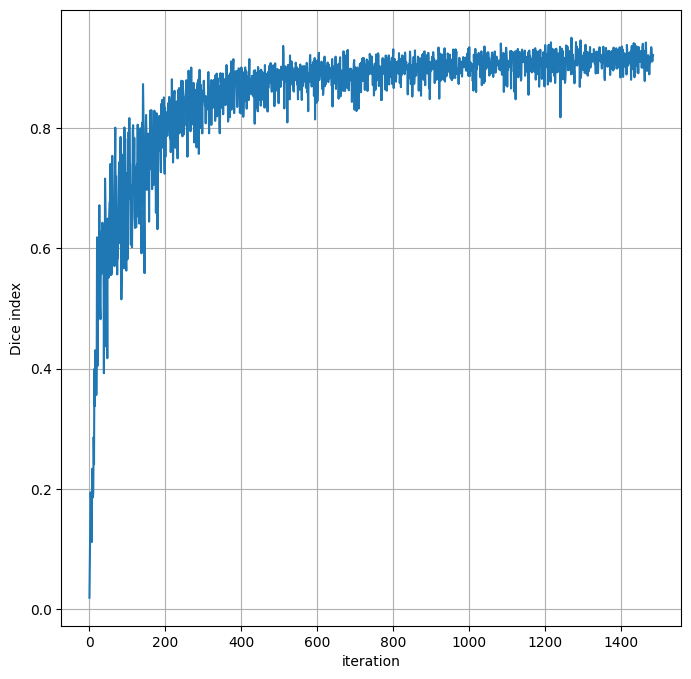

In [10]:
plt.figure(figsize = (8, 8))
plt.plot(dice_idcs)
plt.grid()

plt.xlabel('iteration')
plt.ylabel('Dice index')
plt.show()

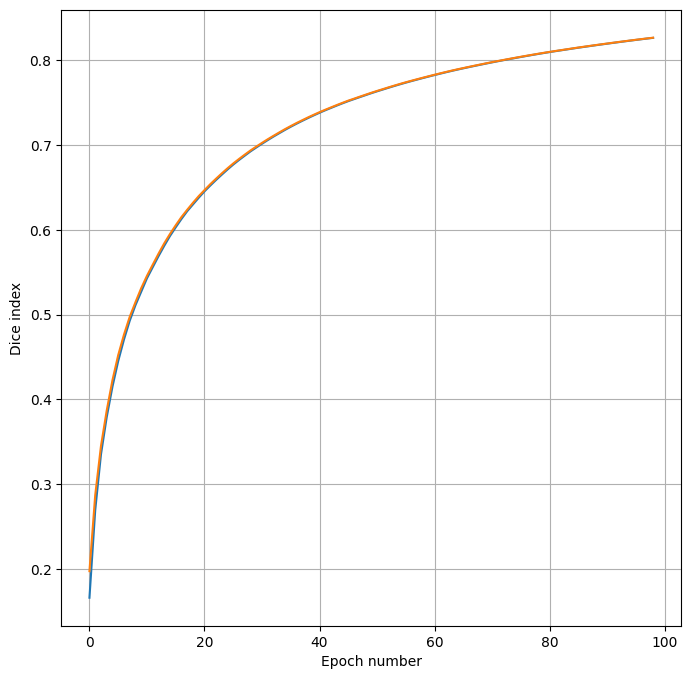

In [11]:
plt.figure(figsize = (8, 8))
plt.plot(epoch_dice_idcs)
plt.plot(val_dice_idcs)
plt.grid()

plt.xlabel('Epoch number')
plt.ylabel('Dice index')
plt.show()

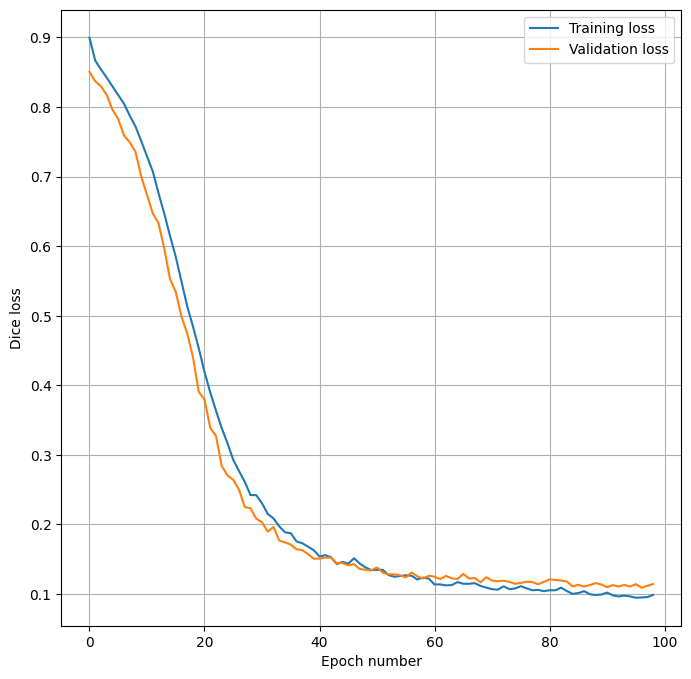

In [12]:
plt.figure(figsize = (8, 8))
plt.plot(train_loss)
plt.plot(val_loss)
plt.grid()

plt.xlabel('Epoch number')
plt.ylabel('Dice loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

In [40]:
import time
t = time.time()
# do stuff
elapsed = time.time() - t
print(elapsed)

0.0


In [19]:
print(img.shape)

torch.Size([3, 384, 544])


C:\Users\Csaba\AppData\Local\Temp\ipykernel_17684\449585325.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img_plot = np.array(img).transpose(1, 2, 0)
C:\Users\Csaba\AppData\Local\Temp\ipykernel_17684\449585325.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  mask_plot = np.array(mask).transpose(1, 2, 0)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8905447].
C:\Users\Csaba\AppDa

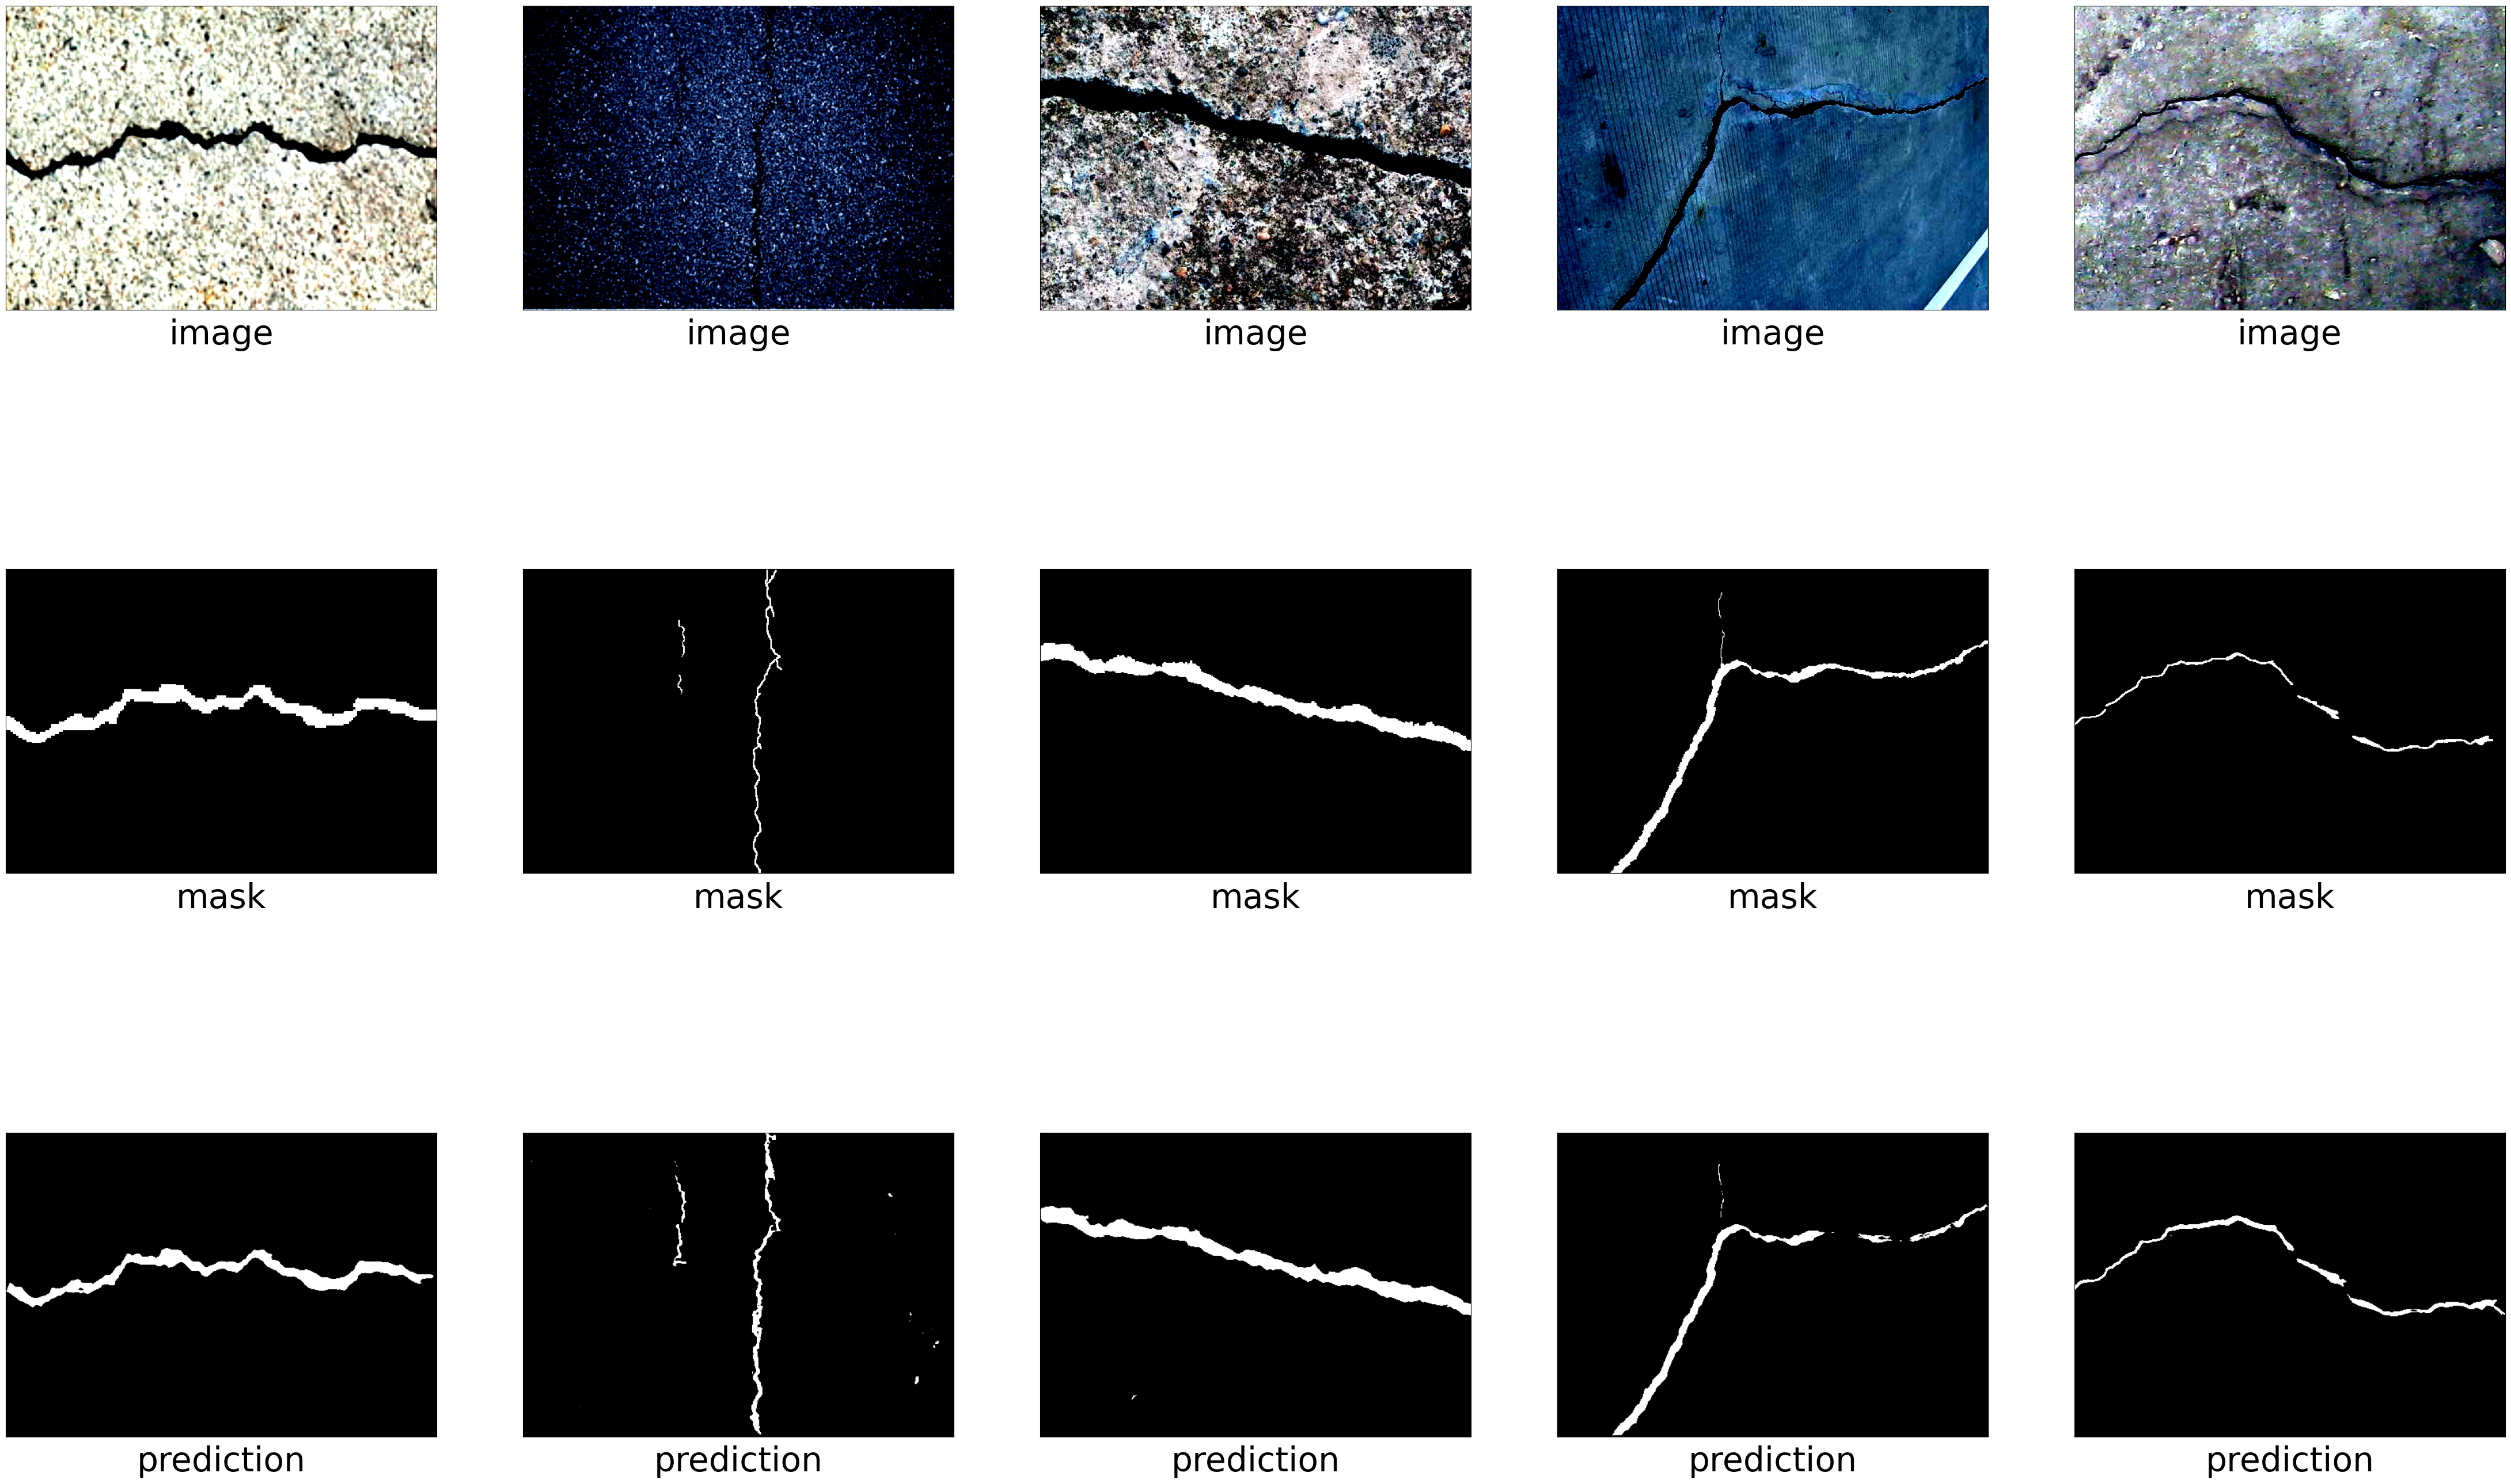

In [14]:
# visualising model predictions
fig = plt.figure(figsize = (56, 36))
for i in range(5):
    img, mask = val_dataset[i].values()

    img_plot = np.array(img).transpose(1, 2, 0)
    mask_plot = np.array(mask).transpose(1, 2, 0)
    subplot = fig.add_subplot(3, 5, i + 1)
    subplot.set_frame_on(True)
    subplot.xaxis.set_ticks_position('none')
    subplot.yaxis.set_ticks_position('none')
    subplot.xaxis.set_ticklabels([])
    subplot.yaxis.set_ticklabels([])
    subplot.xaxis.set_label_text('image', size = 42)
    plt.imshow(img_plot.squeeze())

    subplot = fig.add_subplot(3, 5, i + 6)
    subplot.set_frame_on(True)
    subplot.xaxis.set_ticks_position('none')
    subplot.yaxis.set_ticks_position('none')
    subplot.xaxis.set_ticklabels([])
    subplot.yaxis.set_ticklabels([])
    subplot.xaxis.set_label_text('mask', size = 42)
    plt.imshow(mask_plot.squeeze(), cmap = 'gray')
    #t = time.time()
    with torch.no_grad():
        pred = model(img.to('cuda').reshape((1, *img.shape)))
        #pred = model(img)
    #elapsed = time.time() - t
    #print(elapsed)
    subplot = fig.add_subplot(3, 5, i + 11)
    subplot.set_frame_on(True)
    subplot.xaxis.set_ticks_position('none')
    subplot.yaxis.set_ticks_position('none')
    subplot.xaxis.set_ticklabels([])
    subplot.yaxis.set_ticklabels([])
    subplot.xaxis.set_label_text('prediction', size = 42)
    plt.imshow(pred.cpu().squeeze(), cmap = 'gray')